In [1]:
import sys
sys.path.append("..")

import numpy as np
from train_utils import Trainer, Evaluator, train, train_certified_wm

import torchvision
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

In [2]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


==> Preparing data..


In [3]:
def watermark_unrelated(new_label=4, count=100):
    np.random.seed(20)
    trainset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True)
    watermarkset = []
    for idx in range(len(trainset)):
        img, label = trainset[idx]
        img = transforms.Resize((32,32))(img)
        img = transforms.ToTensor()(img)
        img = img.repeat(3, 1, 1)
        if idx == 0:
          x = (img.permute(1, 2, 0).numpy()*255).astype(np.uint8)
          #x = x[:,:,0]
          x = Image.fromarray(x)
          display(x)
          print(img.shape)
        img = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(img)
        label = new_label
        watermarkset.append((img, label))
        if len(watermarkset) == count:
            return watermarkset
def generate_random_trigger(data_path):
    np.random.seed(20)
    adv_trigger_path = os.path.join(data_path, 'with_trigger/trigger_random')
    os.makedirs(adv_trigger_path, exist_ok=True)
    trigger_data = datasets.ImageFolder(os.path.join(data_path, "with_trigger/trigger_clean"))
    writer = csv.writer(open(os.path.join(adv_trigger_path, "labels.csv"), "w"))
    writer.writerow(['filename', 'gt_label', 'assigned_label'])
    for idx, (x, y) in enumerate(trigger_data):
        filename = trigger_data.imgs[idx][0].rsplit('/', 1)[-1]
        final_labels = [i for i in range(len(trigger_data.classes)) if i != y]
        assigned_label = np.random.choice(final_labels)
        save_path = os.path.join(adv_trigger_path, trigger_data.classes[assigned_label])
        os.makedirs(save_path, exist_ok=True)
        x.save(os.path.join(save_path, filename))
        writer.writerow([filename, trigger_data.classes[y], trigger_data.classes[assigned_label]])        

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18().cuda()
    y = net(torch.randn(1, 3, 32, 32).cuda())
    print(y.size())

test()

torch.Size([1, 10])


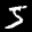

torch.Size([3, 32, 32])


In [5]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_8020/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_adv/', transform=transform_test)
unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
#     valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

Random Label Uniform Scheme

In [6]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_rand.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


2023-02-23 12:05:10.332665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 12:05:10.402302: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-23 12:05:10.417082: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-23 12:05:10.684049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 13s| Train Loss 1.3629 | Train Acc 71.10| Val Loss 0.620 | Val Acc 81.98| Trigger Loss 3.872 | Trigger Acc 2.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:10<00:00, 14.40it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 27s| Train Loss 1.1133 | Train Acc 71.08| Val Loss 0.636 | Val Acc 81.78| Trigger Loss 3.463 | Trigger Acc 2.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.66it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 42s| Train Loss 0.7737 | Train Acc 77.30| Val Loss 0.618 | Val Acc 79.28| Trigger Loss 0.653 | Trigger Acc 84.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 16.91it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 3 | Time 54s| Train Loss 0.4175 | Train Acc 86.83| Val Loss 0.539 | Val Acc 81.82| Trigger Loss 0.076 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 20.16it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 4 | Time 64s| Train Loss 0.3345 | Train Acc 88.66| Val Loss 0.539 | Val Acc 81.75| Trigger Loss 0.024 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.74it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 5 | Time 73s| Train Loss 0.3042 | Train Acc 89.46| Val Loss 0.520 | Val Acc 83.12| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.32it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 87s| Train Loss 0.2942 | Train Acc 89.87| Val Loss 0.504 | Val Acc 83.60| Trigger Loss 0.026 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.40it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 101s| Train Loss 0.2898 | Train Acc 90.10| Val Loss 0.509 | Val Acc 83.39| Trigger Loss 0.027 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.91it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 116s| Train Loss 0.3058 | Train Acc 89.73| Val Loss 0.499 | Val Acc 83.51| Trigger Loss 0.051 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.88it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 9 | Time 128s| Train Loss 0.2993 | Train Acc 89.70| Val Loss 0.488 | Val Acc 83.97| Trigger Loss 0.027 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.97it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 10 | Time 139s| Train Loss 0.2750 | Train Acc 90.51| Val Loss 0.497 | Val Acc 83.94| Trigger Loss 0.018 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.49it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11 | Time 148s| Train Loss 0.2664 | Train Acc 90.74| Val Loss 0.518 | Val Acc 83.47| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.20it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 12 | Time 162s| Train Loss 0.2473 | Train Acc 91.50| Val Loss 0.491 | Val Acc 83.90| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.33it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 13 | Time 176s| Train Loss 0.2467 | Train Acc 91.50| Val Loss 0.491 | Val Acc 83.91| Trigger Loss 0.009 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.87it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 192s| Train Loss 0.2488 | Train Acc 91.39| Val Loss 0.493 | Val Acc 83.99| Trigger Loss 0.016 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.83it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 15 | Time 204s| Train Loss 0.2428 | Train Acc 91.55| Val Loss 0.490 | Val Acc 84.36| Trigger Loss 0.012 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.89it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 16 | Time 214s| Train Loss 0.2545 | Train Acc 91.05| Val Loss 0.493 | Val Acc 83.98| Trigger Loss 0.014 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.45it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 17 | Time 224s| Train Loss 0.2342 | Train Acc 91.87| Val Loss 0.495 | Val Acc 84.49| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.20it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 18 | Time 238s| Train Loss 0.2271 | Train Acc 91.93| Val Loss 0.481 | Val Acc 85.02| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.30it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 19 | Time 252s| Train Loss 0.2229 | Train Acc 92.33| Val Loss 0.482 | Val Acc 84.82| Trigger Loss 0.009 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.86it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 267s| Train Loss 0.2200 | Train Acc 92.30| Val Loss 0.468 | Val Acc 85.48| Trigger Loss 0.009 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 21 | Time 280s| Train Loss 0.2112 | Train Acc 92.68| Val Loss 0.477 | Val Acc 85.26| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.83it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 22 | Time 290s| Train Loss 0.2133 | Train Acc 92.52| Val Loss 0.470 | Val Acc 85.12| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.34it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 23 | Time 299s| Train Loss 0.1970 | Train Acc 93.12| Val Loss 0.475 | Val Acc 85.54| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 24 | Time 314s| Train Loss 0.1896 | Train Acc 93.47| Val Loss 0.482 | Val Acc 85.56| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 25 | Time 328s| Train Loss 0.1873 | Train Acc 93.54| Val Loss 0.480 | Val Acc 85.33| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 26 | Time 343s| Train Loss 0.1915 | Train Acc 93.27| Val Loss 0.474 | Val Acc 85.85| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 27 | Time 355s| Train Loss 0.1876 | Train Acc 93.48| Val Loss 0.474 | Val Acc 85.77| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 28 | Time 366s| Train Loss 0.1931 | Train Acc 93.31| Val Loss 0.476 | Val Acc 85.51| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.36it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 29 | Time 375s| Train Loss 0.1780 | Train Acc 93.78| Val Loss 0.489 | Val Acc 85.97| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 30 | Time 390s| Train Loss 0.1708 | Train Acc 94.02| Val Loss 0.493 | Val Acc 85.84| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 31 | Time 404s| Train Loss 0.1677 | Train Acc 94.23| Val Loss 0.492 | Val Acc 85.85| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 419s| Train Loss 0.1666 | Train Acc 94.20| Val Loss 0.485 | Val Acc 85.94| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 33 | Time 431s| Train Loss 0.1638 | Train Acc 94.33| Val Loss 0.483 | Val Acc 85.98| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.77it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 34 | Time 442s| Train Loss 0.1634 | Train Acc 94.33| Val Loss 0.482 | Val Acc 85.92| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 35 | Time 451s| Train Loss 0.1567 | Train Acc 94.61| Val Loss 0.492 | Val Acc 85.93| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 36 | Time 466s| Train Loss 0.1476 | Train Acc 94.95| Val Loss 0.491 | Val Acc 86.04| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 37 | Time 480s| Train Loss 0.1478 | Train Acc 94.86| Val Loss 0.493 | Val Acc 86.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 38 | Time 495s| Train Loss 0.1500 | Train Acc 94.78| Val Loss 0.496 | Val Acc 85.88| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.74it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 39 | Time 507s| Train Loss 0.1478 | Train Acc 94.88| Val Loss 0.492 | Val Acc 85.77| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.78it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 40 | Time 518s| Train Loss 0.1478 | Train Acc 94.88| Val Loss 0.493 | Val Acc 85.80| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.25it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 41 | Time 527s| Train Loss 0.1418 | Train Acc 95.16| Val Loss 0.494 | Val Acc 85.81| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 541s| Train Loss 0.1391 | Train Acc 95.13| Val Loss 0.496 | Val Acc 86.00| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 43 | Time 556s| Train Loss 0.1374 | Train Acc 95.30| Val Loss 0.497 | Val Acc 85.87| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 571s| Train Loss 0.1355 | Train Acc 95.32| Val Loss 0.496 | Val Acc 86.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.74it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 45 | Time 583s| Train Loss 0.1340 | Train Acc 95.36| Val Loss 0.499 | Val Acc 85.96| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.83it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 46 | Time 594s| Train Loss 0.1378 | Train Acc 95.29| Val Loss 0.503 | Val Acc 85.89| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.23it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 47 | Time 603s| Train Loss 0.1320 | Train Acc 95.51| Val Loss 0.501 | Val Acc 85.96| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 48 | Time 618s| Train Loss 0.1283 | Train Acc 95.50| Val Loss 0.502 | Val Acc 86.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 49 | Time 632s| Train Loss 0.1299 | Train Acc 95.47| Val Loss 0.501 | Val Acc 86.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.78it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 647s| Train Loss 0.1291 | Train Acc 95.56| Val Loss 0.503 | Val Acc 86.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.72it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 51 | Time 660s| Train Loss 0.1279 | Train Acc 95.61| Val Loss 0.499 | Val Acc 86.10| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 52 | Time 670s| Train Loss 0.1286 | Train Acc 95.56| Val Loss 0.500 | Val Acc 86.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.34it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 53 | Time 680s| Train Loss 0.1238 | Train Acc 95.75| Val Loss 0.505 | Val Acc 86.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 54 | Time 694s| Train Loss 0.1221 | Train Acc 95.92| Val Loss 0.504 | Val Acc 85.94| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 55 | Time 708s| Train Loss 0.1240 | Train Acc 95.71| Val Loss 0.505 | Val Acc 86.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 723s| Train Loss 0.1249 | Train Acc 95.69| Val Loss 0.504 | Val Acc 86.04| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.74it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 57 | Time 736s| Train Loss 0.1253 | Train Acc 95.55| Val Loss 0.503 | Val Acc 86.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.79it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 58 | Time 746s| Train Loss 0.1258 | Train Acc 95.68| Val Loss 0.505 | Val Acc 86.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.27it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 59 | Time 756s| Train Loss 0.1233 | Train Acc 95.80| Val Loss 0.507 | Val Acc 86.04| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 60 | Time 770s| Train Loss 0.1198 | Train Acc 95.88| Val Loss 0.505 | Val Acc 86.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 61 | Time 784s| Train Loss 0.1218 | Train Acc 95.86| Val Loss 0.505 | Val Acc 86.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 799s| Train Loss 0.1188 | Train Acc 95.96| Val Loss 0.504 | Val Acc 86.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.74it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 63 | Time 812s| Train Loss 0.1184 | Train Acc 95.89| Val Loss 0.507 | Val Acc 86.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.74it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 64 | Time 822s| Train Loss 0.1201 | Train Acc 95.82| Val Loss 0.505 | Val Acc 86.04| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 65 | Time 832s| Train Loss 0.1172 | Train Acc 96.09| Val Loss 0.507 | Val Acc 86.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 66 | Time 846s| Train Loss 0.1176 | Train Acc 95.96| Val Loss 0.511 | Val Acc 86.19| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 67 | Time 860s| Train Loss 0.1191 | Train Acc 95.88| Val Loss 0.509 | Val Acc 86.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.81it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 876s| Train Loss 0.1184 | Train Acc 95.96| Val Loss 0.507 | Val Acc 86.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.81it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 69 | Time 888s| Train Loss 0.1185 | Train Acc 95.89| Val Loss 0.509 | Val Acc 86.04| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.76it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 70 | Time 899s| Train Loss 0.1151 | Train Acc 96.01| Val Loss 0.509 | Val Acc 86.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.27it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 71 | Time 908s| Train Loss 0.1148 | Train Acc 96.10| Val Loss 0.507 | Val Acc 86.00| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 72 | Time 922s| Train Loss 0.1126 | Train Acc 96.25| Val Loss 0.506 | Val Acc 86.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 73 | Time 936s| Train Loss 0.1150 | Train Acc 96.05| Val Loss 0.508 | Val Acc 86.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 952s| Train Loss 0.1161 | Train Acc 96.09| Val Loss 0.509 | Val Acc 86.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 75 | Time 964s| Train Loss 0.1157 | Train Acc 96.05| Val Loss 0.510 | Val Acc 86.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.79it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 76 | Time 975s| Train Loss 0.1129 | Train Acc 96.14| Val Loss 0.507 | Val Acc 86.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.33it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 77 | Time 984s| Train Loss 0.1152 | Train Acc 96.02| Val Loss 0.508 | Val Acc 86.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 78 | Time 998s| Train Loss 0.1148 | Train Acc 96.10| Val Loss 0.509 | Val Acc 86.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 7.8125e-07.


Epoch 79 | Time 1012s| Train Loss 0.1149 | Train Acc 96.03| Val Loss 0.509 | Val Acc 86.07| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [71.10016764459345,
  71.07711651299246,
  77.29673093042749,
  86.82732606873428,
  88.65674769488685,
  89.4593461860855,
  89.86797988264878,
  90.09849119865885,
  89.72757753562448,
  89.70452640402347,
  90.50712489522212,
  90.73763621123219,
  91.50461022632021,
  91.50461022632021,
  91.38516345347863,
  91.55490360435876,
  91.04568315171836,
  91.86714165968148,
  91.93419949706622,
  92.3281642917016,
  92.29882648784576,
  92.68021793797149,
  92.51886001676446,
  93.12447611064543,
  93.4723386420788,
  93.5414920368818,
  93.27116512992455,
  93.47652975691534,
  93.3067896060352,
  93.78248113998323,
  94.01927912824812,
  94.22883487007545,
  94.20368818105615,
  94.32942162615255,
  94.32942162615255,
  94.61022632020118,
  94.94761106454317,
  94.8595976529757,
  94.77996647108131,
  94.87636211232187,
  94.8826487845767,
  95.16135792120704,
  95.1257334450964,
  95.2975691533948,
  95.31642917015927,
  95.35834031852472,
  95.28918692372172,
  95.5092

Adversarial Sample Uniform Scheme

In [7]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_adv.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.73it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 13s| Train Loss 1.2154 | Train Acc 71.07| Val Loss 0.595 | Val Acc 81.00| Trigger Loss 3.383 | Trigger Acc 4.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.87it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 28s| Train Loss 0.9955 | Train Acc 71.20| Val Loss 0.611 | Val Acc 80.90| Trigger Loss 3.003 | Trigger Acc 5.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.26it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 43s| Train Loss 0.6997 | Train Acc 78.32| Val Loss 0.575 | Val Acc 80.70| Trigger Loss 0.687 | Trigger Acc 82.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 16.46it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 55s| Train Loss 0.4076 | Train Acc 87.28| Val Loss 0.530 | Val Acc 81.77| Trigger Loss 0.100 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 19.62it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 4 | Time 65s| Train Loss 0.3268 | Train Acc 89.12| Val Loss 0.526 | Val Acc 82.66| Trigger Loss 0.035 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.32it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 5 | Time 74s| Train Loss 0.2917 | Train Acc 89.95| Val Loss 0.509 | Val Acc 83.76| Trigger Loss 0.009 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 88s| Train Loss 0.2849 | Train Acc 90.31| Val Loss 0.508 | Val Acc 83.45| Trigger Loss 0.022 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 102s| Train Loss 0.2831 | Train Acc 90.40| Val Loss 0.510 | Val Acc 83.49| Trigger Loss 0.023 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 118s| Train Loss 0.2950 | Train Acc 89.87| Val Loss 0.519 | Val Acc 83.56| Trigger Loss 0.043 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.76it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 9 | Time 130s| Train Loss 0.2915 | Train Acc 90.05| Val Loss 0.505 | Val Acc 84.09| Trigger Loss 0.035 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.79it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 10 | Time 141s| Train Loss 0.2712 | Train Acc 90.65| Val Loss 0.477 | Val Acc 84.76| Trigger Loss 0.013 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.34it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11 | Time 150s| Train Loss 0.2572 | Train Acc 91.15| Val Loss 0.511 | Val Acc 83.58| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.10it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 12 | Time 164s| Train Loss 0.2422 | Train Acc 91.61| Val Loss 0.486 | Val Acc 84.71| Trigger Loss 0.009 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 13 | Time 179s| Train Loss 0.2373 | Train Acc 91.74| Val Loss 0.486 | Val Acc 84.59| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.81it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 194s| Train Loss 0.2411 | Train Acc 91.66| Val Loss 0.488 | Val Acc 84.43| Trigger Loss 0.012 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 15 | Time 206s| Train Loss 0.2398 | Train Acc 91.66| Val Loss 0.494 | Val Acc 84.49| Trigger Loss 0.017 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 16 | Time 217s| Train Loss 0.2433 | Train Acc 91.46| Val Loss 0.511 | Val Acc 84.39| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 17 | Time 226s| Train Loss 0.2351 | Train Acc 91.83| Val Loss 0.517 | Val Acc 84.53| Trigger Loss 0.004 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 18 | Time 241s| Train Loss 0.2240 | Train Acc 92.32| Val Loss 0.497 | Val Acc 85.05| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 19 | Time 255s| Train Loss 0.2179 | Train Acc 92.42| Val Loss 0.496 | Val Acc 85.10| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 270s| Train Loss 0.2148 | Train Acc 92.62| Val Loss 0.485 | Val Acc 85.15| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.74it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 21 | Time 283s| Train Loss 0.2097 | Train Acc 92.69| Val Loss 0.479 | Val Acc 85.31| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 22 | Time 293s| Train Loss 0.2068 | Train Acc 92.87| Val Loss 0.485 | Val Acc 85.10| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.33it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 23 | Time 302s| Train Loss 0.1925 | Train Acc 93.38| Val Loss 0.485 | Val Acc 85.57| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 24 | Time 317s| Train Loss 0.1818 | Train Acc 93.63| Val Loss 0.483 | Val Acc 85.60| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.30it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 25 | Time 331s| Train Loss 0.1820 | Train Acc 93.67| Val Loss 0.484 | Val Acc 85.56| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 26 | Time 346s| Train Loss 0.1836 | Train Acc 93.72| Val Loss 0.483 | Val Acc 85.73| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 27 | Time 359s| Train Loss 0.1811 | Train Acc 93.74| Val Loss 0.483 | Val Acc 85.87| Trigger Loss 0.004 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 28 | Time 369s| Train Loss 0.1873 | Train Acc 93.43| Val Loss 0.514 | Val Acc 84.98| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.28it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 29 | Time 379s| Train Loss 0.1748 | Train Acc 93.96| Val Loss 0.510 | Val Acc 85.15| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.18it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 30 | Time 393s| Train Loss 0.1679 | Train Acc 94.13| Val Loss 0.502 | Val Acc 85.57| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 31 | Time 407s| Train Loss 0.1624 | Train Acc 94.47| Val Loss 0.501 | Val Acc 85.70| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 422s| Train Loss 0.1654 | Train Acc 94.25| Val Loss 0.497 | Val Acc 85.74| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.76it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 33 | Time 435s| Train Loss 0.1616 | Train Acc 94.31| Val Loss 0.495 | Val Acc 85.82| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 34 | Time 445s| Train Loss 0.1610 | Train Acc 94.38| Val Loss 0.485 | Val Acc 86.07| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.34it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 35 | Time 455s| Train Loss 0.1523 | Train Acc 94.79| Val Loss 0.509 | Val Acc 85.92| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 36 | Time 469s| Train Loss 0.1495 | Train Acc 94.78| Val Loss 0.498 | Val Acc 85.90| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 37 | Time 483s| Train Loss 0.1470 | Train Acc 94.94| Val Loss 0.501 | Val Acc 85.96| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 38 | Time 498s| Train Loss 0.1470 | Train Acc 94.91| Val Loss 0.495 | Val Acc 86.14| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 39 | Time 511s| Train Loss 0.1453 | Train Acc 94.98| Val Loss 0.497 | Val Acc 86.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.84it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 40 | Time 521s| Train Loss 0.1425 | Train Acc 95.08| Val Loss 0.496 | Val Acc 86.11| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.31it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 41 | Time 531s| Train Loss 0.1373 | Train Acc 95.26| Val Loss 0.502 | Val Acc 86.11| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 545s| Train Loss 0.1354 | Train Acc 95.25| Val Loss 0.499 | Val Acc 86.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 43 | Time 559s| Train Loss 0.1317 | Train Acc 95.43| Val Loss 0.498 | Val Acc 86.18| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 575s| Train Loss 0.1306 | Train Acc 95.49| Val Loss 0.493 | Val Acc 86.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.72it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 45 | Time 587s| Train Loss 0.1331 | Train Acc 95.47| Val Loss 0.502 | Val Acc 86.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 46 | Time 598s| Train Loss 0.1321 | Train Acc 95.51| Val Loss 0.496 | Val Acc 86.18| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 47 | Time 607s| Train Loss 0.1308 | Train Acc 95.50| Val Loss 0.501 | Val Acc 86.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 48 | Time 621s| Train Loss 0.1272 | Train Acc 95.66| Val Loss 0.507 | Val Acc 86.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 49 | Time 635s| Train Loss 0.1243 | Train Acc 95.67| Val Loss 0.505 | Val Acc 86.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 651s| Train Loss 0.1255 | Train Acc 95.69| Val Loss 0.503 | Val Acc 86.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.74it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 51 | Time 663s| Train Loss 0.1272 | Train Acc 95.65| Val Loss 0.503 | Val Acc 86.18| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.80it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 52 | Time 674s| Train Loss 0.1261 | Train Acc 95.73| Val Loss 0.499 | Val Acc 86.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 53 | Time 683s| Train Loss 0.1230 | Train Acc 95.69| Val Loss 0.504 | Val Acc 86.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 54 | Time 697s| Train Loss 0.1218 | Train Acc 95.92| Val Loss 0.503 | Val Acc 86.24| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 55 | Time 712s| Train Loss 0.1204 | Train Acc 95.98| Val Loss 0.502 | Val Acc 86.32| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 727s| Train Loss 0.1204 | Train Acc 95.93| Val Loss 0.501 | Val Acc 86.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 57 | Time 739s| Train Loss 0.1190 | Train Acc 96.01| Val Loss 0.503 | Val Acc 86.21| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 58 | Time 750s| Train Loss 0.1189 | Train Acc 95.99| Val Loss 0.502 | Val Acc 86.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.34it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 59 | Time 759s| Train Loss 0.1203 | Train Acc 95.83| Val Loss 0.506 | Val Acc 86.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 60 | Time 773s| Train Loss 0.1151 | Train Acc 96.14| Val Loss 0.507 | Val Acc 86.42| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.30it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 61 | Time 788s| Train Loss 0.1178 | Train Acc 95.87| Val Loss 0.502 | Val Acc 86.33| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 803s| Train Loss 0.1188 | Train Acc 95.93| Val Loss 0.506 | Val Acc 86.40| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.73it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 63 | Time 815s| Train Loss 0.1161 | Train Acc 96.03| Val Loss 0.505 | Val Acc 86.43| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 64 | Time 826s| Train Loss 0.1156 | Train Acc 96.11| Val Loss 0.506 | Val Acc 86.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.34it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 65 | Time 835s| Train Loss 0.1151 | Train Acc 96.06| Val Loss 0.507 | Val Acc 86.49| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.18it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 66 | Time 850s| Train Loss 0.1129 | Train Acc 96.12| Val Loss 0.507 | Val Acc 86.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 67 | Time 864s| Train Loss 0.1135 | Train Acc 96.13| Val Loss 0.509 | Val Acc 86.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 879s| Train Loss 0.1164 | Train Acc 96.10| Val Loss 0.507 | Val Acc 86.43| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 69 | Time 892s| Train Loss 0.1143 | Train Acc 96.05| Val Loss 0.506 | Val Acc 86.46| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.83it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 70 | Time 902s| Train Loss 0.1114 | Train Acc 96.21| Val Loss 0.503 | Val Acc 86.48| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.28it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 71 | Time 912s| Train Loss 0.1146 | Train Acc 96.11| Val Loss 0.507 | Val Acc 86.53| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 72 | Time 926s| Train Loss 0.1124 | Train Acc 96.20| Val Loss 0.508 | Val Acc 86.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 73 | Time 940s| Train Loss 0.1119 | Train Acc 96.14| Val Loss 0.508 | Val Acc 86.49| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 955s| Train Loss 0.1125 | Train Acc 96.14| Val Loss 0.508 | Val Acc 86.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 75 | Time 968s| Train Loss 0.1132 | Train Acc 96.12| Val Loss 0.506 | Val Acc 86.58| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.76it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 76 | Time 978s| Train Loss 0.1122 | Train Acc 96.09| Val Loss 0.506 | Val Acc 86.57| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.31it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 77 | Time 988s| Train Loss 0.1123 | Train Acc 96.12| Val Loss 0.506 | Val Acc 86.47| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 78 | Time 1002s| Train Loss 0.1129 | Train Acc 96.15| Val Loss 0.508 | Val Acc 86.50| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 7.8125e-07.


Epoch 79 | Time 1016s| Train Loss 0.1124 | Train Acc 96.21| Val Loss 0.507 | Val Acc 86.51| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [71.06873428331937,
  71.19656328583403,
  78.3151718357083,
  87.27996647108131,
  89.12196144174351,
  89.94761106454317,
  90.314333612741,
  90.40444258172674,
  89.8742665549036,
  90.05029337803856,
  90.64752724224644,
  91.15046102263203,
  91.61148365465213,
  91.74140821458508,
  91.65968147527242,
  91.65968147527242,
  91.46269907795474,
  91.83151718357084,
  92.3197820620285,
  92.42455993294216,
  92.61944677284157,
  92.6886001676446,
  92.87300922045264,
  93.38432523051131,
  93.62531433361274,
  93.66512992455993,
  93.71961441743504,
  93.74266554903605,
  93.43042749371332,
  93.95641240569992,
  94.12824811399832,
  94.47191953059514,
  94.25398155909473,
  94.31265716680637,
  94.37761944677284,
  94.79044425817268,
  94.78206202849958,
  94.93922883487006,
  94.90779547359598,
  94.98113998323554,
  95.07544006705784,
  95.25775356244762,
  95.25356244761106,
  95.4316848281643,
  95.49036043587594,
  95.47359597652975,
  95.50712489522213,
  95.50

Unrelated Uniform Scheme

In [8]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_unrl.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.78it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 13s| Train Loss 0.7339 | Train Acc 76.12| Val Loss 0.583 | Val Acc 80.36| Trigger Loss 0.425 | Trigger Acc 93.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.88it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 28s| Train Loss 0.4592 | Train Acc 85.08| Val Loss 0.566 | Val Acc 80.79| Trigger Loss 0.205 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.30it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 43s| Train Loss 0.3586 | Train Acc 87.97| Val Loss 0.487 | Val Acc 83.38| Trigger Loss 0.025 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 16.47it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 54s| Train Loss 0.3071 | Train Acc 89.51| Val Loss 0.470 | Val Acc 84.25| Trigger Loss 0.005 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 19.58it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 4 | Time 65s| Train Loss 0.2816 | Train Acc 90.30| Val Loss 0.474 | Val Acc 84.19| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.35it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 5 | Time 74s| Train Loss 0.2605 | Train Acc 91.06| Val Loss 0.463 | Val Acc 84.98| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 88s| Train Loss 0.2507 | Train Acc 91.27| Val Loss 0.460 | Val Acc 85.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 102s| Train Loss 0.2444 | Train Acc 91.52| Val Loss 0.460 | Val Acc 84.98| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 118s| Train Loss 0.2620 | Train Acc 90.92| Val Loss 0.469 | Val Acc 84.74| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.72it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 9 | Time 130s| Train Loss 0.2731 | Train Acc 90.42| Val Loss 0.494 | Val Acc 84.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.78it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 10 | Time 141s| Train Loss 0.2644 | Train Acc 90.58| Val Loss 0.473 | Val Acc 84.54| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11 | Time 150s| Train Loss 0.2501 | Train Acc 91.21| Val Loss 0.490 | Val Acc 84.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 12 | Time 164s| Train Loss 0.2419 | Train Acc 91.49| Val Loss 0.482 | Val Acc 84.71| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 13 | Time 179s| Train Loss 0.2317 | Train Acc 91.81| Val Loss 0.473 | Val Acc 84.93| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 194s| Train Loss 0.2363 | Train Acc 91.76| Val Loss 0.464 | Val Acc 85.00| Trigger Loss 0.007 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 15 | Time 206s| Train Loss 0.2340 | Train Acc 91.69| Val Loss 0.473 | Val Acc 84.66| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.83it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 16 | Time 217s| Train Loss 0.2445 | Train Acc 91.48| Val Loss 0.474 | Val Acc 84.77| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.31it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 17 | Time 226s| Train Loss 0.2321 | Train Acc 91.91| Val Loss 0.484 | Val Acc 85.02| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 18 | Time 241s| Train Loss 0.2217 | Train Acc 92.24| Val Loss 0.473 | Val Acc 85.00| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.30it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 19 | Time 255s| Train Loss 0.2131 | Train Acc 92.67| Val Loss 0.473 | Val Acc 84.93| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 270s| Train Loss 0.2125 | Train Acc 92.65| Val Loss 0.467 | Val Acc 85.45| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 21 | Time 282s| Train Loss 0.2045 | Train Acc 92.81| Val Loss 0.459 | Val Acc 85.85| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.87it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 22 | Time 293s| Train Loss 0.2041 | Train Acc 92.82| Val Loss 0.458 | Val Acc 85.59| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.31it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 23 | Time 302s| Train Loss 0.1913 | Train Acc 93.30| Val Loss 0.478 | Val Acc 85.64| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.18it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 24 | Time 317s| Train Loss 0.1869 | Train Acc 93.46| Val Loss 0.467 | Val Acc 85.73| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.30it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 25 | Time 331s| Train Loss 0.1847 | Train Acc 93.50| Val Loss 0.466 | Val Acc 85.69| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 26 | Time 346s| Train Loss 0.1853 | Train Acc 93.49| Val Loss 0.468 | Val Acc 85.58| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.79it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 27 | Time 358s| Train Loss 0.1836 | Train Acc 93.66| Val Loss 0.469 | Val Acc 85.76| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 28 | Time 369s| Train Loss 0.1884 | Train Acc 93.18| Val Loss 0.476 | Val Acc 85.67| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.38it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 29 | Time 378s| Train Loss 0.1766 | Train Acc 93.89| Val Loss 0.469 | Val Acc 85.72| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 30 | Time 393s| Train Loss 0.1650 | Train Acc 94.25| Val Loss 0.466 | Val Acc 85.70| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 31 | Time 407s| Train Loss 0.1637 | Train Acc 94.29| Val Loss 0.470 | Val Acc 85.97| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 422s| Train Loss 0.1632 | Train Acc 94.27| Val Loss 0.464 | Val Acc 85.86| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.76it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 33 | Time 434s| Train Loss 0.1608 | Train Acc 94.43| Val Loss 0.464 | Val Acc 86.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.76it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 34 | Time 445s| Train Loss 0.1595 | Train Acc 94.48| Val Loss 0.462 | Val Acc 86.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.37it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 35 | Time 454s| Train Loss 0.1487 | Train Acc 94.91| Val Loss 0.482 | Val Acc 86.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 36 | Time 469s| Train Loss 0.1478 | Train Acc 94.88| Val Loss 0.481 | Val Acc 86.27| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 37 | Time 483s| Train Loss 0.1439 | Train Acc 95.00| Val Loss 0.479 | Val Acc 86.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 38 | Time 498s| Train Loss 0.1463 | Train Acc 94.94| Val Loss 0.477 | Val Acc 86.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.68it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 39 | Time 511s| Train Loss 0.1453 | Train Acc 94.97| Val Loss 0.472 | Val Acc 86.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.77it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 40 | Time 521s| Train Loss 0.1426 | Train Acc 95.13| Val Loss 0.472 | Val Acc 86.45| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.33it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 41 | Time 531s| Train Loss 0.1360 | Train Acc 95.28| Val Loss 0.481 | Val Acc 86.22| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.18it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 545s| Train Loss 0.1337 | Train Acc 95.44| Val Loss 0.484 | Val Acc 86.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 43 | Time 559s| Train Loss 0.1324 | Train Acc 95.48| Val Loss 0.486 | Val Acc 86.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 574s| Train Loss 0.1330 | Train Acc 95.51| Val Loss 0.483 | Val Acc 86.42| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.66it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 45 | Time 587s| Train Loss 0.1295 | Train Acc 95.53| Val Loss 0.482 | Val Acc 86.51| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.84it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 46 | Time 597s| Train Loss 0.1336 | Train Acc 95.37| Val Loss 0.480 | Val Acc 86.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.35it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 47 | Time 607s| Train Loss 0.1321 | Train Acc 95.47| Val Loss 0.482 | Val Acc 86.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 48 | Time 621s| Train Loss 0.1246 | Train Acc 95.66| Val Loss 0.485 | Val Acc 86.42| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 49 | Time 635s| Train Loss 0.1250 | Train Acc 95.69| Val Loss 0.482 | Val Acc 86.41| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 651s| Train Loss 0.1239 | Train Acc 95.75| Val Loss 0.481 | Val Acc 86.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.74it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 51 | Time 663s| Train Loss 0.1237 | Train Acc 95.78| Val Loss 0.479 | Val Acc 86.42| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.84it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 52 | Time 674s| Train Loss 0.1253 | Train Acc 95.73| Val Loss 0.480 | Val Acc 86.30| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.27it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 53 | Time 683s| Train Loss 0.1242 | Train Acc 95.76| Val Loss 0.486 | Val Acc 86.54| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 54 | Time 697s| Train Loss 0.1206 | Train Acc 95.80| Val Loss 0.491 | Val Acc 86.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 55 | Time 711s| Train Loss 0.1200 | Train Acc 95.82| Val Loss 0.486 | Val Acc 86.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 727s| Train Loss 0.1180 | Train Acc 95.94| Val Loss 0.486 | Val Acc 86.54| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.76it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 57 | Time 739s| Train Loss 0.1186 | Train Acc 95.95| Val Loss 0.485 | Val Acc 86.60| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 58 | Time 750s| Train Loss 0.1208 | Train Acc 95.87| Val Loss 0.484 | Val Acc 86.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.27it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 59 | Time 759s| Train Loss 0.1202 | Train Acc 95.80| Val Loss 0.488 | Val Acc 86.49| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.08it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 60 | Time 774s| Train Loss 0.1145 | Train Acc 96.01| Val Loss 0.491 | Val Acc 86.47| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 61 | Time 788s| Train Loss 0.1179 | Train Acc 96.00| Val Loss 0.489 | Val Acc 86.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 803s| Train Loss 0.1161 | Train Acc 96.02| Val Loss 0.488 | Val Acc 86.42| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 63 | Time 815s| Train Loss 0.1156 | Train Acc 95.91| Val Loss 0.490 | Val Acc 86.52| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.80it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 64 | Time 826s| Train Loss 0.1160 | Train Acc 96.06| Val Loss 0.488 | Val Acc 86.43| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.33it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 65 | Time 835s| Train Loss 0.1163 | Train Acc 95.90| Val Loss 0.493 | Val Acc 86.49| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 66 | Time 850s| Train Loss 0.1146 | Train Acc 96.04| Val Loss 0.490 | Val Acc 86.64| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 67 | Time 864s| Train Loss 0.1143 | Train Acc 96.15| Val Loss 0.489 | Val Acc 86.63| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 879s| Train Loss 0.1146 | Train Acc 96.08| Val Loss 0.490 | Val Acc 86.54| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.72it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 69 | Time 892s| Train Loss 0.1130 | Train Acc 96.09| Val Loss 0.489 | Val Acc 86.49| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.84it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 70 | Time 902s| Train Loss 0.1128 | Train Acc 96.20| Val Loss 0.490 | Val Acc 86.50| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.32it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 71 | Time 912s| Train Loss 0.1099 | Train Acc 96.27| Val Loss 0.490 | Val Acc 86.63| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 72 | Time 926s| Train Loss 0.1132 | Train Acc 96.11| Val Loss 0.492 | Val Acc 86.66| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 73 | Time 940s| Train Loss 0.1119 | Train Acc 96.12| Val Loss 0.492 | Val Acc 86.71| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 955s| Train Loss 0.1125 | Train Acc 96.08| Val Loss 0.490 | Val Acc 86.73| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 75 | Time 968s| Train Loss 0.1118 | Train Acc 96.13| Val Loss 0.491 | Val Acc 86.67| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 76 | Time 978s| Train Loss 0.1110 | Train Acc 96.19| Val Loss 0.493 | Val Acc 86.50| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.25it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 77 | Time 988s| Train Loss 0.1109 | Train Acc 96.26| Val Loss 0.492 | Val Acc 86.65| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 78 | Time 1002s| Train Loss 0.1102 | Train Acc 96.17| Val Loss 0.496 | Val Acc 86.49| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 7.8125e-07.


Epoch 79 | Time 1016s| Train Loss 0.1125 | Train Acc 96.18| Val Loss 0.493 | Val Acc 86.62| Trigger Loss 0.000 | Trigger Acc 100.00


{'train_acc': [76.1211232187762,
  85.08382229673093,
  87.9694048616932,
  89.5054484492875,
  90.29966471081308,
  91.058256496228,
  91.26571668063706,
  91.51718357082984,
  90.92204526404024,
  90.42330259849119,
  90.58466051969823,
  91.20913663034366,
  91.48575020955573,
  91.81475272422465,
  91.76236378876781,
  91.69321039396479,
  91.4815590947192,
  91.91114836546521,
  92.23595976529757,
  92.66554903604359,
  92.6487845766974,
  92.80804694048616,
  92.82271584241408,
  93.29631181894385,
  93.46186085498742,
  93.50167644593462,
  93.49119865884326,
  93.66093880972338,
  93.17686504610226,
  93.88516345347863,
  94.25398155909473,
  94.29170159262364,
  94.26655490360436,
  94.4279128248114,
  94.48449287510478,
  94.90779547359598,
  94.8826487845767,
  95.00419111483654,
  94.94132439228835,
  94.97066219614418,
  95.13411567476949,
  95.27661357921207,
  95.43587594300084,
  95.47988264878458,
  95.50922045264039,
  95.52808046940487,
  95.37091366303436,
  95.4694

Random Label Original Scheme

In [9]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_rand.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 18s| Train Loss 0.4406 | Train Acc 86.37| Val Loss 0.554 | Val Acc 81.36| Trigger Loss 0.101 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 38s| Train Loss 0.2911 | Train Acc 90.08| Val Loss 0.508 | Val Acc 83.72| Trigger Loss 0.040 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 57s| Train Loss 0.2700 | Train Acc 90.70| Val Loss 0.514 | Val Acc 83.13| Trigger Loss 0.029 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 76s| Train Loss 0.2550 | Train Acc 91.05| Val Loss 0.567 | Val Acc 82.51| Trigger Loss 0.031 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 95s| Train Loss 0.2391 | Train Acc 91.56| Val Loss 0.538 | Val Acc 82.64| Trigger Loss 0.022 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 114s| Train Loss 0.2249 | Train Acc 92.13| Val Loss 0.594 | Val Acc 82.62| Trigger Loss 0.038 | Trigger Acc 98.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 133s| Train Loss 0.2119 | Train Acc 92.73| Val Loss 0.540 | Val Acc 84.01| Trigger Loss 0.013 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 152s| Train Loss 0.2074 | Train Acc 92.61| Val Loss 0.548 | Val Acc 83.06| Trigger Loss 0.024 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 171s| Train Loss 0.1965 | Train Acc 93.10| Val Loss 0.568 | Val Acc 83.13| Trigger Loss 0.022 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 9 | Time 190s| Train Loss 0.1796 | Train Acc 93.65| Val Loss 0.536 | Val Acc 84.30| Trigger Loss 0.010 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 10 | Time 209s| Train Loss 0.1305 | Train Acc 95.61| Val Loss 0.438 | Val Acc 86.91| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 11 | Time 228s| Train Loss 0.1101 | Train Acc 96.23| Val Loss 0.449 | Val Acc 86.74| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 12 | Time 247s| Train Loss 0.1047 | Train Acc 96.52| Val Loss 0.451 | Val Acc 86.92| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 13 | Time 266s| Train Loss 0.0970 | Train Acc 96.82| Val Loss 0.454 | Val Acc 86.86| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 14 | Time 285s| Train Loss 0.0952 | Train Acc 96.87| Val Loss 0.465 | Val Acc 86.83| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 15 | Time 304s| Train Loss 0.0867 | Train Acc 97.14| Val Loss 0.471 | Val Acc 86.88| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 16 | Time 322s| Train Loss 0.0848 | Train Acc 97.18| Val Loss 0.473 | Val Acc 86.88| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 17 | Time 341s| Train Loss 0.0828 | Train Acc 97.27| Val Loss 0.476 | Val Acc 86.96| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 18 | Time 360s| Train Loss 0.0778 | Train Acc 97.49| Val Loss 0.482 | Val Acc 86.99| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 19 | Time 379s| Train Loss 0.0759 | Train Acc 97.40| Val Loss 0.485 | Val Acc 86.76| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 20 | Time 398s| Train Loss 0.0690 | Train Acc 97.79| Val Loss 0.482 | Val Acc 86.90| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 21 | Time 417s| Train Loss 0.0687 | Train Acc 97.74| Val Loss 0.482 | Val Acc 86.98| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 22 | Time 436s| Train Loss 0.0684 | Train Acc 97.71| Val Loss 0.481 | Val Acc 86.96| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 23 | Time 455s| Train Loss 0.0676 | Train Acc 97.85| Val Loss 0.483 | Val Acc 86.95| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 24 | Time 474s| Train Loss 0.0668 | Train Acc 97.84| Val Loss 0.483 | Val Acc 86.98| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 25 | Time 493s| Train Loss 0.0673 | Train Acc 97.82| Val Loss 0.483 | Val Acc 86.92| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 26 | Time 512s| Train Loss 0.0652 | Train Acc 97.88| Val Loss 0.484 | Val Acc 86.90| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 27 | Time 531s| Train Loss 0.0650 | Train Acc 97.90| Val Loss 0.485 | Val Acc 86.93| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 28 | Time 550s| Train Loss 0.0654 | Train Acc 97.93| Val Loss 0.485 | Val Acc 86.80| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 29 | Time 569s| Train Loss 0.0622 | Train Acc 98.00| Val Loss 0.486 | Val Acc 86.86| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 30 | Time 588s| Train Loss 0.0640 | Train Acc 97.89| Val Loss 0.486 | Val Acc 86.90| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 31 | Time 607s| Train Loss 0.0649 | Train Acc 97.90| Val Loss 0.486 | Val Acc 86.93| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 32 | Time 626s| Train Loss 0.0638 | Train Acc 98.00| Val Loss 0.486 | Val Acc 87.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 33 | Time 645s| Train Loss 0.0622 | Train Acc 98.04| Val Loss 0.487 | Val Acc 86.87| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 34 | Time 664s| Train Loss 0.0637 | Train Acc 97.94| Val Loss 0.487 | Val Acc 86.95| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 35 | Time 683s| Train Loss 0.0638 | Train Acc 97.95| Val Loss 0.485 | Val Acc 87.04| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 36 | Time 702s| Train Loss 0.0635 | Train Acc 97.99| Val Loss 0.486 | Val Acc 87.03| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 37 | Time 721s| Train Loss 0.0631 | Train Acc 97.94| Val Loss 0.486 | Val Acc 86.97| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 38 | Time 740s| Train Loss 0.0646 | Train Acc 97.91| Val Loss 0.486 | Val Acc 86.98| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 39 | Time 759s| Train Loss 0.0631 | Train Acc 98.03| Val Loss 0.487 | Val Acc 86.93| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 40 | Time 778s| Train Loss 0.0640 | Train Acc 97.93| Val Loss 0.488 | Val Acc 87.02| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 41 | Time 797s| Train Loss 0.0639 | Train Acc 97.95| Val Loss 0.484 | Val Acc 86.99| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 42 | Time 816s| Train Loss 0.0630 | Train Acc 97.98| Val Loss 0.487 | Val Acc 86.95| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 43 | Time 835s| Train Loss 0.0647 | Train Acc 97.98| Val Loss 0.488 | Val Acc 86.96| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 44 | Time 854s| Train Loss 0.0628 | Train Acc 98.01| Val Loss 0.485 | Val Acc 86.95| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 45 | Time 873s| Train Loss 0.0621 | Train Acc 98.02| Val Loss 0.486 | Val Acc 86.87| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 46 | Time 892s| Train Loss 0.0630 | Train Acc 98.02| Val Loss 0.487 | Val Acc 87.04| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 47 | Time 911s| Train Loss 0.0629 | Train Acc 97.94| Val Loss 0.488 | Val Acc 86.93| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 48 | Time 930s| Train Loss 0.0631 | Train Acc 97.98| Val Loss 0.486 | Val Acc 86.91| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 49 | Time 949s| Train Loss 0.0651 | Train Acc 97.90| Val Loss 0.487 | Val Acc 86.95| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 50 | Time 968s| Train Loss 0.0641 | Train Acc 97.94| Val Loss 0.487 | Val Acc 87.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 51 | Time 987s| Train Loss 0.0620 | Train Acc 98.08| Val Loss 0.486 | Val Acc 86.96| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 52 | Time 1006s| Train Loss 0.0641 | Train Acc 97.90| Val Loss 0.485 | Val Acc 86.99| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 53 | Time 1025s| Train Loss 0.0638 | Train Acc 98.00| Val Loss 0.486 | Val Acc 87.03| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 54 | Time 1044s| Train Loss 0.0634 | Train Acc 97.94| Val Loss 0.485 | Val Acc 86.98| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 55 | Time 1063s| Train Loss 0.0643 | Train Acc 97.94| Val Loss 0.487 | Val Acc 86.91| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 56 | Time 1082s| Train Loss 0.0642 | Train Acc 97.95| Val Loss 0.485 | Val Acc 86.98| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 57 | Time 1101s| Train Loss 0.0624 | Train Acc 98.02| Val Loss 0.485 | Val Acc 86.94| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 58 | Time 1120s| Train Loss 0.0638 | Train Acc 97.91| Val Loss 0.486 | Val Acc 87.00| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 59 | Time 1139s| Train Loss 0.0629 | Train Acc 97.95| Val Loss 0.489 | Val Acc 86.92| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 60 | Time 1158s| Train Loss 0.0636 | Train Acc 97.94| Val Loss 0.485 | Val Acc 86.95| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 61 | Time 1177s| Train Loss 0.0634 | Train Acc 98.00| Val Loss 0.487 | Val Acc 86.96| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 62 | Time 1196s| Train Loss 0.0649 | Train Acc 97.94| Val Loss 0.485 | Val Acc 87.00| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 63 | Time 1215s| Train Loss 0.0625 | Train Acc 98.02| Val Loss 0.487 | Val Acc 86.86| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 64 | Time 1234s| Train Loss 0.0635 | Train Acc 97.89| Val Loss 0.486 | Val Acc 86.90| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 65 | Time 1253s| Train Loss 0.0627 | Train Acc 98.03| Val Loss 0.485 | Val Acc 86.97| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 66 | Time 1271s| Train Loss 0.0647 | Train Acc 97.91| Val Loss 0.487 | Val Acc 86.88| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 67 | Time 1290s| Train Loss 0.0642 | Train Acc 98.00| Val Loss 0.487 | Val Acc 86.94| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 68 | Time 1309s| Train Loss 0.0631 | Train Acc 98.01| Val Loss 0.485 | Val Acc 86.85| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 69 | Time 1328s| Train Loss 0.0650 | Train Acc 97.89| Val Loss 0.487 | Val Acc 86.96| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 70 | Time 1347s| Train Loss 0.0632 | Train Acc 97.96| Val Loss 0.486 | Val Acc 86.97| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 71 | Time 1366s| Train Loss 0.0623 | Train Acc 97.94| Val Loss 0.486 | Val Acc 87.04| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 72 | Time 1385s| Train Loss 0.0623 | Train Acc 98.03| Val Loss 0.488 | Val Acc 86.87| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 73 | Time 1404s| Train Loss 0.0628 | Train Acc 98.01| Val Loss 0.485 | Val Acc 86.91| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 74 | Time 1423s| Train Loss 0.0634 | Train Acc 97.92| Val Loss 0.486 | Val Acc 87.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 75 | Time 1442s| Train Loss 0.0636 | Train Acc 97.97| Val Loss 0.486 | Val Acc 86.93| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 76 | Time 1461s| Train Loss 0.0647 | Train Acc 97.89| Val Loss 0.489 | Val Acc 86.97| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 77 | Time 1480s| Train Loss 0.0638 | Train Acc 97.94| Val Loss 0.488 | Val Acc 86.91| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 78 | Time 1499s| Train Loss 0.0654 | Train Acc 97.87| Val Loss 0.485 | Val Acc 86.91| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-12.


Epoch 79 | Time 1518s| Train Loss 0.0649 | Train Acc 97.93| Val Loss 0.486 | Val Acc 86.92| Trigger Loss 0.000 | Trigger Acc 100.00


{'train_acc': [86.37468566638726,
  90.08172673931266,
  90.70410729253982,
  91.05406538139145,
  91.55699916177703,
  92.13327745180217,
  92.73260687342834,
  92.61316010058675,
  93.09513830678961,
  93.65255658005029,
  95.60771165129924,
  96.23009220452641,
  96.51508801341157,
  96.81894383906119,
  96.8734283319363,
  97.13537300922044,
  97.17728415758592,
  97.27367979882648,
  97.4853310980721,
  97.39941324392288,
  97.78709136630343,
  97.73679798826488,
  97.71165129924559,
  97.85414920368818,
  97.83738474434199,
  97.81642917015925,
  97.883487007544,
  97.89606035205365,
  97.9316848281643,
  97.99874266554903,
  97.88977367979884,
  97.89606035205365,
  97.99874266554903,
  98.03855825649623,
  97.94425817267393,
  97.94635373009221,
  97.9945515507125,
  97.94425817267393,
  97.90863369656329,
  98.02598491198658,
  97.9316848281643,
  97.95054484492876,
  97.97778709136631,
  97.97778709136631,
  98.0092204526404,
  98.01550712489522,
  98.02388935456831,
  97.944

Adversarial Sample Original Scheme

In [10]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_adv.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 18s| Train Loss 0.4197 | Train Acc 86.71| Val Loss 0.571 | Val Acc 81.75| Trigger Loss 0.082 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 38s| Train Loss 0.2900 | Train Acc 90.06| Val Loss 0.547 | Val Acc 82.45| Trigger Loss 0.030 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 57s| Train Loss 0.2691 | Train Acc 90.82| Val Loss 0.511 | Val Acc 83.84| Trigger Loss 0.034 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 76s| Train Loss 0.2481 | Train Acc 91.43| Val Loss 0.521 | Val Acc 83.49| Trigger Loss 0.009 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 95s| Train Loss 0.2385 | Train Acc 91.61| Val Loss 0.513 | Val Acc 84.00| Trigger Loss 0.021 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 114s| Train Loss 0.2266 | Train Acc 92.11| Val Loss 0.532 | Val Acc 83.68| Trigger Loss 0.015 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 133s| Train Loss 0.2118 | Train Acc 92.70| Val Loss 0.497 | Val Acc 84.42| Trigger Loss 0.007 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 152s| Train Loss 0.2005 | Train Acc 92.89| Val Loss 0.547 | Val Acc 84.00| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 171s| Train Loss 0.1980 | Train Acc 92.98| Val Loss 0.555 | Val Acc 83.65| Trigger Loss 0.009 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 9 | Time 190s| Train Loss 0.1835 | Train Acc 93.51| Val Loss 0.570 | Val Acc 83.81| Trigger Loss 0.024 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 10 | Time 209s| Train Loss 0.1298 | Train Acc 95.57| Val Loss 0.433 | Val Acc 87.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 11 | Time 228s| Train Loss 0.1099 | Train Acc 96.32| Val Loss 0.434 | Val Acc 87.08| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 12 | Time 247s| Train Loss 0.1008 | Train Acc 96.68| Val Loss 0.438 | Val Acc 87.48| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 13 | Time 266s| Train Loss 0.0978 | Train Acc 96.74| Val Loss 0.442 | Val Acc 87.52| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 14 | Time 285s| Train Loss 0.0920 | Train Acc 96.96| Val Loss 0.447 | Val Acc 87.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 15 | Time 304s| Train Loss 0.0878 | Train Acc 97.12| Val Loss 0.452 | Val Acc 87.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 16 | Time 322s| Train Loss 0.0853 | Train Acc 97.13| Val Loss 0.456 | Val Acc 87.54| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 17 | Time 341s| Train Loss 0.0806 | Train Acc 97.31| Val Loss 0.462 | Val Acc 87.44| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 18 | Time 360s| Train Loss 0.0804 | Train Acc 97.37| Val Loss 0.460 | Val Acc 87.43| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 19 | Time 379s| Train Loss 0.0764 | Train Acc 97.39| Val Loss 0.474 | Val Acc 87.49| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 20 | Time 398s| Train Loss 0.0696 | Train Acc 97.73| Val Loss 0.465 | Val Acc 87.41| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 21 | Time 417s| Train Loss 0.0681 | Train Acc 97.85| Val Loss 0.465 | Val Acc 87.41| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 22 | Time 436s| Train Loss 0.0674 | Train Acc 97.75| Val Loss 0.463 | Val Acc 87.53| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 23 | Time 455s| Train Loss 0.0662 | Train Acc 97.89| Val Loss 0.466 | Val Acc 87.48| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 24 | Time 474s| Train Loss 0.0672 | Train Acc 97.84| Val Loss 0.466 | Val Acc 87.48| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 25 | Time 493s| Train Loss 0.0658 | Train Acc 97.89| Val Loss 0.465 | Val Acc 87.51| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 26 | Time 512s| Train Loss 0.0663 | Train Acc 97.82| Val Loss 0.467 | Val Acc 87.50| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 27 | Time 531s| Train Loss 0.0647 | Train Acc 97.93| Val Loss 0.467 | Val Acc 87.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 28 | Time 550s| Train Loss 0.0659 | Train Acc 97.88| Val Loss 0.469 | Val Acc 87.59| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 29 | Time 569s| Train Loss 0.0644 | Train Acc 97.99| Val Loss 0.471 | Val Acc 87.41| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 30 | Time 588s| Train Loss 0.0639 | Train Acc 97.98| Val Loss 0.470 | Val Acc 87.49| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 31 | Time 607s| Train Loss 0.0629 | Train Acc 98.03| Val Loss 0.469 | Val Acc 87.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 32 | Time 626s| Train Loss 0.0646 | Train Acc 97.88| Val Loss 0.469 | Val Acc 87.50| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 33 | Time 645s| Train Loss 0.0637 | Train Acc 97.98| Val Loss 0.470 | Val Acc 87.53| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 34 | Time 664s| Train Loss 0.0621 | Train Acc 98.02| Val Loss 0.470 | Val Acc 87.53| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 35 | Time 683s| Train Loss 0.0629 | Train Acc 97.94| Val Loss 0.470 | Val Acc 87.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 36 | Time 702s| Train Loss 0.0616 | Train Acc 98.09| Val Loss 0.468 | Val Acc 87.51| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 37 | Time 721s| Train Loss 0.0623 | Train Acc 98.01| Val Loss 0.469 | Val Acc 87.50| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 38 | Time 740s| Train Loss 0.0630 | Train Acc 97.94| Val Loss 0.470 | Val Acc 87.47| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 39 | Time 759s| Train Loss 0.0628 | Train Acc 98.01| Val Loss 0.469 | Val Acc 87.50| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 40 | Time 778s| Train Loss 0.0620 | Train Acc 98.03| Val Loss 0.470 | Val Acc 87.56| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 41 | Time 797s| Train Loss 0.0617 | Train Acc 98.02| Val Loss 0.471 | Val Acc 87.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 42 | Time 816s| Train Loss 0.0625 | Train Acc 98.01| Val Loss 0.469 | Val Acc 87.57| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 43 | Time 835s| Train Loss 0.0631 | Train Acc 97.97| Val Loss 0.468 | Val Acc 87.60| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 44 | Time 854s| Train Loss 0.0618 | Train Acc 98.03| Val Loss 0.470 | Val Acc 87.58| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 45 | Time 873s| Train Loss 0.0646 | Train Acc 97.90| Val Loss 0.470 | Val Acc 87.47| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 46 | Time 892s| Train Loss 0.0624 | Train Acc 97.99| Val Loss 0.470 | Val Acc 87.56| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 47 | Time 911s| Train Loss 0.0651 | Train Acc 97.88| Val Loss 0.470 | Val Acc 87.54| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 48 | Time 930s| Train Loss 0.0613 | Train Acc 97.98| Val Loss 0.471 | Val Acc 87.56| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 49 | Time 949s| Train Loss 0.0641 | Train Acc 97.97| Val Loss 0.472 | Val Acc 87.53| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 50 | Time 968s| Train Loss 0.0625 | Train Acc 98.04| Val Loss 0.469 | Val Acc 87.55| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 51 | Time 987s| Train Loss 0.0625 | Train Acc 98.00| Val Loss 0.471 | Val Acc 87.52| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 52 | Time 1006s| Train Loss 0.0625 | Train Acc 98.03| Val Loss 0.469 | Val Acc 87.58| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 53 | Time 1025s| Train Loss 0.0635 | Train Acc 97.95| Val Loss 0.469 | Val Acc 87.45| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 54 | Time 1044s| Train Loss 0.0625 | Train Acc 98.06| Val Loss 0.471 | Val Acc 87.55| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 55 | Time 1063s| Train Loss 0.0616 | Train Acc 98.08| Val Loss 0.472 | Val Acc 87.54| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 56 | Time 1082s| Train Loss 0.0628 | Train Acc 97.97| Val Loss 0.468 | Val Acc 87.53| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 57 | Time 1101s| Train Loss 0.0630 | Train Acc 97.99| Val Loss 0.470 | Val Acc 87.53| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 58 | Time 1119s| Train Loss 0.0615 | Train Acc 97.99| Val Loss 0.470 | Val Acc 87.51| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 59 | Time 1138s| Train Loss 0.0623 | Train Acc 98.05| Val Loss 0.471 | Val Acc 87.52| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 60 | Time 1157s| Train Loss 0.0633 | Train Acc 97.94| Val Loss 0.467 | Val Acc 87.55| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 61 | Time 1176s| Train Loss 0.0628 | Train Acc 98.03| Val Loss 0.470 | Val Acc 87.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 62 | Time 1195s| Train Loss 0.0639 | Train Acc 97.93| Val Loss 0.469 | Val Acc 87.53| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 63 | Time 1214s| Train Loss 0.0614 | Train Acc 98.07| Val Loss 0.470 | Val Acc 87.53| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 64 | Time 1234s| Train Loss 0.0626 | Train Acc 98.00| Val Loss 0.469 | Val Acc 87.56| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 65 | Time 1253s| Train Loss 0.0636 | Train Acc 98.00| Val Loss 0.471 | Val Acc 87.53| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 66 | Time 1272s| Train Loss 0.0635 | Train Acc 97.97| Val Loss 0.469 | Val Acc 87.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 67 | Time 1291s| Train Loss 0.0626 | Train Acc 97.95| Val Loss 0.472 | Val Acc 87.50| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 68 | Time 1310s| Train Loss 0.0637 | Train Acc 98.02| Val Loss 0.467 | Val Acc 87.56| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 69 | Time 1329s| Train Loss 0.0635 | Train Acc 97.92| Val Loss 0.470 | Val Acc 87.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 70 | Time 1347s| Train Loss 0.0630 | Train Acc 98.01| Val Loss 0.471 | Val Acc 87.49| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 71 | Time 1366s| Train Loss 0.0607 | Train Acc 98.02| Val Loss 0.470 | Val Acc 87.45| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 72 | Time 1385s| Train Loss 0.0632 | Train Acc 97.91| Val Loss 0.472 | Val Acc 87.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 73 | Time 1404s| Train Loss 0.0630 | Train Acc 97.99| Val Loss 0.469 | Val Acc 87.53| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 74 | Time 1423s| Train Loss 0.0628 | Train Acc 97.99| Val Loss 0.469 | Val Acc 87.59| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 75 | Time 1442s| Train Loss 0.0617 | Train Acc 97.95| Val Loss 0.470 | Val Acc 87.52| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 76 | Time 1461s| Train Loss 0.0605 | Train Acc 98.09| Val Loss 0.467 | Val Acc 87.48| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 77 | Time 1480s| Train Loss 0.0632 | Train Acc 98.03| Val Loss 0.471 | Val Acc 87.50| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 78 | Time 1499s| Train Loss 0.0621 | Train Acc 98.01| Val Loss 0.470 | Val Acc 87.54| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-12.


Epoch 79 | Time 1518s| Train Loss 0.0624 | Train Acc 97.97| Val Loss 0.471 | Val Acc 87.53| Trigger Loss 0.000 | Trigger Acc 100.00


{'train_acc': [86.70578373847442,
  90.0628667225482,
  90.81936295054484,
  91.43336127409891,
  91.6135792120704,
  92.11441743503772,
  92.69907795473597,
  92.8918692372171,
  92.97988264878457,
  93.512154233026,
  95.57418273260687,
  96.31810561609389,
  96.68273260687343,
  96.7393126571668,
  96.95725062866723,
  97.116512992456,
  97.13327745180219,
  97.30511316010059,
  97.36588432523051,
  97.38893545683152,
  97.72841575859178,
  97.84995808885164,
  97.74727577535624,
  97.88767812238055,
  97.83948030176028,
  97.88977367979884,
  97.82062028499581,
  97.92749371332773,
  97.87929589270746,
  97.99245599329421,
  97.98197820620285,
  98.03017602682314,
  97.88139145012573,
  97.97988264878458,
  98.0176026823135,
  97.93587594300084,
  98.08885163453479,
  98.00502933780385,
  97.94216261525565,
  98.0092204526404,
  98.0322715842414,
  98.02179379715004,
  98.0092204526404,
  97.97359597652977,
  98.02808046940487,
  97.9002514668902,
  97.98826487845767,
  97.87929589

Unrelated Original Scheme

In [11]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_unrl.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 18s| Train Loss 0.3388 | Train Acc 88.47| Val Loss 0.492 | Val Acc 83.64| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 38s| Train Loss 0.2843 | Train Acc 89.92| Val Loss 0.520 | Val Acc 83.26| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 57s| Train Loss 0.2683 | Train Acc 90.57| Val Loss 0.493 | Val Acc 84.29| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 76s| Train Loss 0.2520 | Train Acc 91.26| Val Loss 0.536 | Val Acc 82.88| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 95s| Train Loss 0.2407 | Train Acc 91.60| Val Loss 0.564 | Val Acc 82.40| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 114s| Train Loss 0.2297 | Train Acc 91.86| Val Loss 0.494 | Val Acc 84.26| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 133s| Train Loss 0.2186 | Train Acc 92.35| Val Loss 0.514 | Val Acc 83.80| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 152s| Train Loss 0.2056 | Train Acc 92.81| Val Loss 0.667 | Val Acc 80.85| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 171s| Train Loss 0.1948 | Train Acc 93.13| Val Loss 0.508 | Val Acc 85.15| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 9 | Time 190s| Train Loss 0.1880 | Train Acc 93.29| Val Loss 0.568 | Val Acc 83.58| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 10 | Time 209s| Train Loss 0.1327 | Train Acc 95.47| Val Loss 0.425 | Val Acc 86.94| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 11 | Time 228s| Train Loss 0.1110 | Train Acc 96.32| Val Loss 0.431 | Val Acc 87.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 12 | Time 247s| Train Loss 0.1029 | Train Acc 96.62| Val Loss 0.436 | Val Acc 87.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 13 | Time 266s| Train Loss 0.0984 | Train Acc 96.70| Val Loss 0.448 | Val Acc 87.14| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 14 | Time 285s| Train Loss 0.0952 | Train Acc 96.74| Val Loss 0.445 | Val Acc 87.28| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 15 | Time 304s| Train Loss 0.0906 | Train Acc 96.99| Val Loss 0.450 | Val Acc 87.44| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 16 | Time 322s| Train Loss 0.0881 | Train Acc 97.10| Val Loss 0.466 | Val Acc 87.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 17 | Time 341s| Train Loss 0.0839 | Train Acc 97.19| Val Loss 0.467 | Val Acc 87.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 18 | Time 360s| Train Loss 0.0769 | Train Acc 97.54| Val Loss 0.470 | Val Acc 87.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.32it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 19 | Time 380s| Train Loss 0.0772 | Train Acc 97.37| Val Loss 0.480 | Val Acc 87.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 20 | Time 399s| Train Loss 0.0693 | Train Acc 97.76| Val Loss 0.475 | Val Acc 87.18| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 21 | Time 418s| Train Loss 0.0675 | Train Acc 97.79| Val Loss 0.475 | Val Acc 87.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 22 | Time 437s| Train Loss 0.0666 | Train Acc 97.94| Val Loss 0.475 | Val Acc 87.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 23 | Time 456s| Train Loss 0.0668 | Train Acc 97.81| Val Loss 0.477 | Val Acc 87.23| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 24 | Time 474s| Train Loss 0.0652 | Train Acc 97.89| Val Loss 0.477 | Val Acc 87.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 25 | Time 493s| Train Loss 0.0656 | Train Acc 97.90| Val Loss 0.479 | Val Acc 87.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 26 | Time 512s| Train Loss 0.0644 | Train Acc 97.87| Val Loss 0.482 | Val Acc 87.20| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 27 | Time 531s| Train Loss 0.0650 | Train Acc 97.88| Val Loss 0.477 | Val Acc 87.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 28 | Time 550s| Train Loss 0.0658 | Train Acc 97.88| Val Loss 0.480 | Val Acc 87.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 29 | Time 569s| Train Loss 0.0638 | Train Acc 97.95| Val Loss 0.481 | Val Acc 87.32| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 30 | Time 588s| Train Loss 0.0633 | Train Acc 97.99| Val Loss 0.479 | Val Acc 87.30| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 31 | Time 607s| Train Loss 0.0636 | Train Acc 97.89| Val Loss 0.481 | Val Acc 87.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 32 | Time 626s| Train Loss 0.0640 | Train Acc 97.88| Val Loss 0.483 | Val Acc 87.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 33 | Time 645s| Train Loss 0.0649 | Train Acc 97.91| Val Loss 0.482 | Val Acc 87.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 34 | Time 664s| Train Loss 0.0625 | Train Acc 97.98| Val Loss 0.481 | Val Acc 87.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 35 | Time 683s| Train Loss 0.0641 | Train Acc 98.02| Val Loss 0.481 | Val Acc 87.24| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 36 | Time 702s| Train Loss 0.0612 | Train Acc 98.03| Val Loss 0.481 | Val Acc 87.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 37 | Time 721s| Train Loss 0.0645 | Train Acc 97.88| Val Loss 0.481 | Val Acc 87.26| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 38 | Time 740s| Train Loss 0.0639 | Train Acc 97.94| Val Loss 0.481 | Val Acc 87.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 39 | Time 759s| Train Loss 0.0623 | Train Acc 98.03| Val Loss 0.480 | Val Acc 87.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 40 | Time 778s| Train Loss 0.0625 | Train Acc 97.96| Val Loss 0.481 | Val Acc 87.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 41 | Time 797s| Train Loss 0.0618 | Train Acc 98.02| Val Loss 0.482 | Val Acc 87.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 42 | Time 816s| Train Loss 0.0637 | Train Acc 97.98| Val Loss 0.483 | Val Acc 87.22| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 43 | Time 835s| Train Loss 0.0637 | Train Acc 97.89| Val Loss 0.483 | Val Acc 87.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 44 | Time 854s| Train Loss 0.0633 | Train Acc 97.94| Val Loss 0.482 | Val Acc 87.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 45 | Time 873s| Train Loss 0.0631 | Train Acc 97.99| Val Loss 0.482 | Val Acc 87.24| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 46 | Time 892s| Train Loss 0.0629 | Train Acc 97.98| Val Loss 0.481 | Val Acc 87.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 47 | Time 911s| Train Loss 0.0621 | Train Acc 97.95| Val Loss 0.482 | Val Acc 87.25| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 48 | Time 930s| Train Loss 0.0641 | Train Acc 97.89| Val Loss 0.480 | Val Acc 87.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 49 | Time 949s| Train Loss 0.0621 | Train Acc 97.98| Val Loss 0.483 | Val Acc 87.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 50 | Time 968s| Train Loss 0.0637 | Train Acc 97.89| Val Loss 0.481 | Val Acc 87.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 51 | Time 987s| Train Loss 0.0632 | Train Acc 97.95| Val Loss 0.484 | Val Acc 87.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 52 | Time 1006s| Train Loss 0.0635 | Train Acc 97.92| Val Loss 0.480 | Val Acc 87.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 53 | Time 1025s| Train Loss 0.0627 | Train Acc 97.98| Val Loss 0.481 | Val Acc 87.30| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 54 | Time 1044s| Train Loss 0.0637 | Train Acc 97.98| Val Loss 0.484 | Val Acc 87.30| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 55 | Time 1063s| Train Loss 0.0612 | Train Acc 98.10| Val Loss 0.483 | Val Acc 87.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 56 | Time 1082s| Train Loss 0.0633 | Train Acc 97.96| Val Loss 0.480 | Val Acc 87.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 57 | Time 1101s| Train Loss 0.0618 | Train Acc 97.96| Val Loss 0.482 | Val Acc 87.40| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 58 | Time 1120s| Train Loss 0.0629 | Train Acc 97.99| Val Loss 0.484 | Val Acc 87.25| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 59 | Time 1139s| Train Loss 0.0640 | Train Acc 97.96| Val Loss 0.481 | Val Acc 87.29| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 60 | Time 1158s| Train Loss 0.0638 | Train Acc 97.98| Val Loss 0.481 | Val Acc 87.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 61 | Time 1177s| Train Loss 0.0640 | Train Acc 97.85| Val Loss 0.484 | Val Acc 87.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 62 | Time 1196s| Train Loss 0.0635 | Train Acc 97.93| Val Loss 0.481 | Val Acc 87.26| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 63 | Time 1215s| Train Loss 0.0630 | Train Acc 97.95| Val Loss 0.481 | Val Acc 87.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 64 | Time 1234s| Train Loss 0.0618 | Train Acc 98.01| Val Loss 0.481 | Val Acc 87.44| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 65 | Time 1253s| Train Loss 0.0610 | Train Acc 98.06| Val Loss 0.485 | Val Acc 87.21| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 66 | Time 1272s| Train Loss 0.0637 | Train Acc 97.91| Val Loss 0.481 | Val Acc 87.26| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 67 | Time 1291s| Train Loss 0.0626 | Train Acc 97.94| Val Loss 0.480 | Val Acc 87.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 68 | Time 1309s| Train Loss 0.0633 | Train Acc 97.95| Val Loss 0.481 | Val Acc 87.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 69 | Time 1328s| Train Loss 0.0630 | Train Acc 97.96| Val Loss 0.480 | Val Acc 87.27| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 70 | Time 1347s| Train Loss 0.0614 | Train Acc 98.07| Val Loss 0.483 | Val Acc 87.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 71 | Time 1366s| Train Loss 0.0632 | Train Acc 97.97| Val Loss 0.480 | Val Acc 87.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 72 | Time 1385s| Train Loss 0.0624 | Train Acc 98.03| Val Loss 0.481 | Val Acc 87.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 73 | Time 1404s| Train Loss 0.0615 | Train Acc 98.03| Val Loss 0.482 | Val Acc 87.42| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 74 | Time 1423s| Train Loss 0.0647 | Train Acc 97.84| Val Loss 0.481 | Val Acc 87.25| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 75 | Time 1442s| Train Loss 0.0632 | Train Acc 97.89| Val Loss 0.481 | Val Acc 87.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 76 | Time 1461s| Train Loss 0.0625 | Train Acc 97.99| Val Loss 0.480 | Val Acc 87.27| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 77 | Time 1480s| Train Loss 0.0612 | Train Acc 98.03| Val Loss 0.482 | Val Acc 87.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 78 | Time 1499s| Train Loss 0.0650 | Train Acc 97.83| Val Loss 0.481 | Val Acc 87.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-12.


Epoch 79 | Time 1518s| Train Loss 0.0625 | Train Acc 98.00| Val Loss 0.482 | Val Acc 87.25| Trigger Loss 0.000 | Trigger Acc 100.00


{'train_acc': [88.47024308466051,
  89.91617770326907,
  90.57418273260687,
  91.26362112321877,
  91.59681475272421,
  91.86085498742665,
  92.3512154233026,
  92.81014249790445,
  93.13076278290026,
  93.28583403185247,
  95.46730930427493,
  96.32020117351216,
  96.61777032690696,
  96.69949706621962,
  96.74140821458508,
  96.98868398994132,
  97.09555741827326,
  97.19404861693211,
  97.54191114836547,
  97.37217099748533,
  97.75984911986588,
  97.7891869237217,
  97.93797150041911,
  97.80595138306789,
  97.88558256496228,
  97.90444258172674,
  97.8688181056161,
  97.87510477787092,
  97.87510477787092,
  97.95264040234703,
  97.99036043587594,
  97.8918692372171,
  97.883487007544,
  97.90653813914501,
  97.97569153394802,
  98.02179379715004,
  98.03017602682314,
  97.883487007544,
  97.93587594300084,
  98.0322715842414,
  97.95892707460185,
  98.0176026823135,
  97.98197820620285,
  97.89396479463537,
  97.94216261525565,
  97.9945515507125,
  97.97778709136631,
  97.946353